## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [1]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK

In [3]:
#loading
egoalter = pd.read_csv('./EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('./EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [5]:
# Apply the default theme
sns.set()

In [6]:
egoalter

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False
...,...,...,...,...,...,...,...,...,...
2516185,2516186,False,5129.0,191,403.0,10800.0,ar,Mon Jun 23 22:56:28 +0000 2014,False
2516186,2516187,False,6694.0,11,1523.0,-14400.0,en,Wed Jul 08 09:10:18 +0000 2009,False
2516187,2516188,False,6651.0,216,7141.0,-18000.0,en,Thu Jun 16 00:06:46 +0000 2011,False
2516188,2516189,False,21.0,59,33.0,NaN,en,Fri Nov 30 05:31:27 +0000 2012,False


In [7]:
def extract_info(df):
    
    n = len(df)
    interact1 = n - np.sum(df['replyto_userid'].isnull())
    interact2 = n - np.sum(df['mentions_ids'].isnull())
    
    popular1 = np.nansum(df['retweet_count'])
    
    return [interact1, interact2, popular1, n]

In [8]:
interact1s, interact2s = [], []
popular1 = []
activity = []
ids = []

for _id in tqdm(egotimes['egoID'].unique()):
    int1, int2, pop1, n = extract_info(egotimes.loc[egotimes['egoID']==_id])
    interact1s.append(int1) ; interact2s.append(int2)
    popular1.append(pop1)
    activity.append(n)
    ids.append(_id)

100%|████████████████████████████████████████████████████████████████████████████| 17244/17244 [03:12<00:00, 89.76it/s]


In [10]:
df = pd.DataFrame(list(zip(interact1s, interact2s, popular1, activity, ids)), 
               columns =['interact1', 'interact2', 'popular1', 'activity', 'id']) 

In [11]:
df

,interact1,interact2,popular1,activity,id
0,4,8,0,9,1
1,2,2,0,7,2
2,0,0,0,68,4
3,334,348,26408,742,5
4,0,6,0,7,8
...,...,...,...,...,...
17239,0,1,1,1,33993
17240,0,0,0,1,33998
17241,0,1,3,1,34000
17242,0,3,9,3,34001


In [37]:
from sklearn.cluster import KMeans

[[  12.26616018   25.38917379]
 [1463.17725753 1888.49832776]
 [ 428.60324826  859.11020882]
 [ 458.18055556 2085.03125   ]]


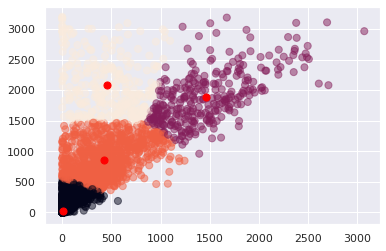

In [42]:
kmeans = KMeans(n_clusters=4).fit(df.iloc[:,:2])
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['interact1'], df['interact2'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

[[4.31407095e+04 2.50056518e+02]
 [2.25848488e+07 2.46477273e+03]
 [4.80615259e+06 1.93572959e+03]
 [7.34576974e+07 2.48360000e+03]]


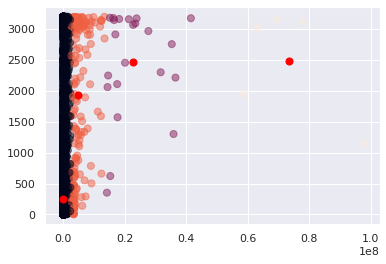

In [43]:
kmeans = KMeans(n_clusters=4).fit(df.iloc[:,2:4])
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['popular1'], df['activity'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# DBSCAN clustering

In [35]:
norm_df = ((df-df.min())/(df.max()-df.min()))*20

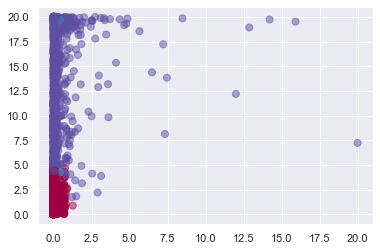

In [63]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1., min_samples=5).fit(norm_df)
unique_labels = set(dbscan.labels_)
unique_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
color_dict = dict(zip(unique_labels, unique_colors))
labels = dbscan.labels_
colors = []
for label in labels:
    colors.append(color_dict[label])
plt.scatter(norm_df['popular1'], norm_df['activity'], c=colors, s=50, alpha=0.5) 
plt.show()

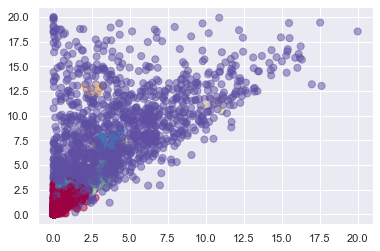

In [64]:
plt.scatter(norm_df['interact1'], norm_df['interact2'], c=colors, s=50, alpha=0.5) 
plt.show()

In [65]:
max(norm_df['popular1']), min(norm_df['popular1'])

(20.0, 0.0)

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(norm_df.values.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [67]:
new_vectors = pca.components_
new_vectors.shape

(2, 17244)

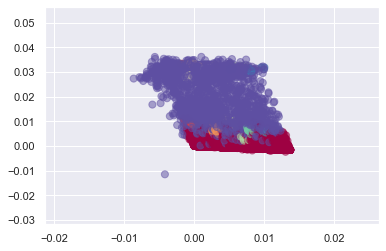

In [68]:
plt.scatter(new_vectors[0, :], new_vectors[1, :], c=colors, s=50, alpha=0.5) 
plt.show()